In [1]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import logging
logger = logging.getLogger(__name__)
import gc

In [2]:
import os, yaml
from argparse import Namespace

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.metrics import average_precision_score, f1_score

from tqdm import tqdm

import torch
from torch import nn

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
from torch.nn.modules.loss import CrossEntropyLoss
from pytorch_lightning import seed_everything



import wandb
os.environ["WANDB_SILENT"] = "true"
wandb.login(key = "27edf9c66b032c03f72d30e923276b93aa736429")

True

In [6]:
import sys
sys.path.append('/scratch/work/masooda1/ToxBERT/src')

from molbert.models.smiles import SmilesMolbertModel
from molbert.datasets.dataloading import MolbertDataLoader
from molbert.datasets.smiles import BertSmilesDataset
from molbert.utils.featurizer.molfeaturizer import SmilesIndexFeaturizer

In [7]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts, StepLR
from transformers import (
    AdamW,
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup,
    get_constant_schedule_with_warmup,
    get_cosine_with_hard_restarts_schedule_with_warmup,
)

In [5]:
# config_dict
model_weights_dir = '/projects/home/mmasood1/Model_weights/invitro/invitro_1million/MolBERT/Retrain_on_top_of_BERT/complete_1m_300k_ADME/ADME_masking_invitro_physchem_init_pretrained/'
pretrained_model_path = '/projects/home/mmasood1/TG GATE/MolBERT/molbert/molbert_100epochs/molbert_100epochs/checkpoints/last.ckpt'
data_dir = '/projects/home/mmasood1/arslan_data_repository/invitro/invitro_1m/25_04_2024/SMILES_len_th_128/'
pos_weights = "/projects/home/mmasood1/arslan_data_repository/invitro/invitro_1m/25_04_2024/pos_weights.csv"
metadata_dir = "/projects/home/mmasood1/trained_model_predictions/SIDER_PreClinical/BERT_finetune/MF/"
model_dir = os.path.dirname(os.path.dirname(pretrained_model_path))
hparams_path = os.path.join(model_dir, 'hparams.yaml')
# load config
with open(hparams_path) as yaml_file:
    config_dict = yaml.load(yaml_file, Loader=yaml.FullLoader)

config_dict['project_name'] = "BERT_invitro_ADME_pretraining"
config_dict['model_name'] = "ADME_masking_invitro_physchem_init_pretrained"

config_dict['model_weights_dir'] = model_weights_dir
config_dict['pretrained_model_path'] = pretrained_model_path
config_dict["metadata_dir"] = metadata_dir
config_dict['pos_weights'] = pos_weights
config_dict['data_dir'] = data_dir
config_dict['train_file'] = data_dir + "train_set_invitro_1m_300k_ADME_filtered.pkl"
config_dict['valid_file'] = data_dir + "test_set_invitro_1m_300k_ADME_filtered.pkl"
config_dict['test_file'] = data_dir + "test_set_invitro_1m_300k_ADME_filtered.pkl"

config_dict['mode'] = 'classification'
config_dict['alpha'] = 0.0
config_dict['beta'] = 0.0
config_dict['gamma'] = 0.0

config_dict['max_epochs'] = 50
config_dict['unfreeze_epoch'] = 210
config_dict["l2_lambda"] = 0.0
config_dict['embedding_size'] = 50
config_dict["num_physchem_properties"] = 200
config_dict["num_invivo_tasks"] = 0

config_dict['optim'] = 'AdamW'#SGD
config_dict['loss_type'] = 'BCE'# Focal_loss

config_dict['lr'] = 1e-05
config_dict["BERT_lr"] = 3e-5
config_dict["batch_size"] = 264
config_dict["seed"] = 42



config_dict['missing'] = 'nan'
config_dict['compute_metric_after_n_epochs'] = 5
config_dict['return_trainer'] = True
config_dict['EarlyStopping'] = False

config_dict["accelerator"] = "gpu"
config_dict["device"] = torch.device("cuda")


data = pd.read_pickle(config_dict['train_file'])
data.drop(['SMILES'], axis = 1, inplace = True)
target_names = data.columns.tolist()

config_dict["output_size"] = len(target_names)
config_dict["num_invitro_tasks"] = len(target_names)
config_dict["num_of_tasks"] = len(target_names)

config_dict["label_column"] = target_names
config_dict["selected_tasks"] = target_names
config_dict['num_mols'] = data.shape[0]
config_dict['max_seq_length'] = 128
config_dict['bert_output_dim'] = 768
config_dict['invitro_head_hidden_layer'] = 2048

config_dict["permute"] = False

config_dict['pretrained_model'] = True
config_dict['freeze_level'] = False
config_dict["gpu"] = -1
config_dict["precision"] = 32
config_dict["distributed_backend"] = "dp"

FileNotFoundError: [Errno 2] No such file or directory: '/projects/home/mmasood1/TG GATE/MolBERT/molbert/molbert_100epochs/molbert_100epochs/hparams.yaml'

In [8]:
chembl20 = pd.read_parquet("/scratch/work/masooda1/mocop/data/chembl20/chembl20.parquet")
chembl20.head()

,smiles,0,1,2,3,4,5,6,7,8,...,1300,1301,1302,1303,1304,1305,1306,1307,1308,1309
0,c1ccc2cc(CC3=NCCN3)ccc2c1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,CCCCCCC=CCCCCCCCc1cccc(O)c1C(=O)O,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,CC(=O)c1cc2c(cc1O)OC(C)(C)C=C2,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,CCCCCn1cc(C(=O)NC2C3CC4CC(C3)CC2C4)c(=O)c2ccccc21,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,[H]C12Cc3c([nH]c4ccccc34)C(c3ccccc3)N1C(=O)C(C...,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [9]:
# 1. First filter assays (columns) as before
pos_counts_assays = (chembl20.iloc[:, 1:] == 1).sum(axis=0)
neg_counts_assays = (chembl20.iloc[:, 1:] == 0).sum(axis=0)
valid_assays = (pos_counts_assays >= 10) & (neg_counts_assays >= 10)
selected_columns = ['smiles'] + valid_assays[valid_assays].index.tolist()

# Get intermediate filtered dataset by assays
filtered_by_assays = chembl20[selected_columns]

# 2. Then filter drugs (rows) that have at least 10 pos and 10 neg
pos_counts_drugs = (filtered_by_assays.iloc[:, 1:] == 1).sum(axis=1)
neg_counts_drugs = (filtered_by_assays.iloc[:, 1:] == 0).sum(axis=1)

# 3. total measurements per drug
measurements_per_drug_filtered = (filtered_by_assays.iloc[:, 1:] != -1).sum(axis=1).sort_values(ascending=False)

# Print statistics
print(f"Original number of assays: {chembl20.shape[1]-1}")  # -1 for smiles column
print(f"Number of assays with ≥100 pos and neg: {len(selected_columns)-1}")  # -1 for smiles column
print(f"Shape of filtered dataset: {filtered_by_assays.shape}")

Original number of assays: 1310
Number of assays with ≥100 pos and neg: 1245
Shape of filtered dataset: (449390, 1246)


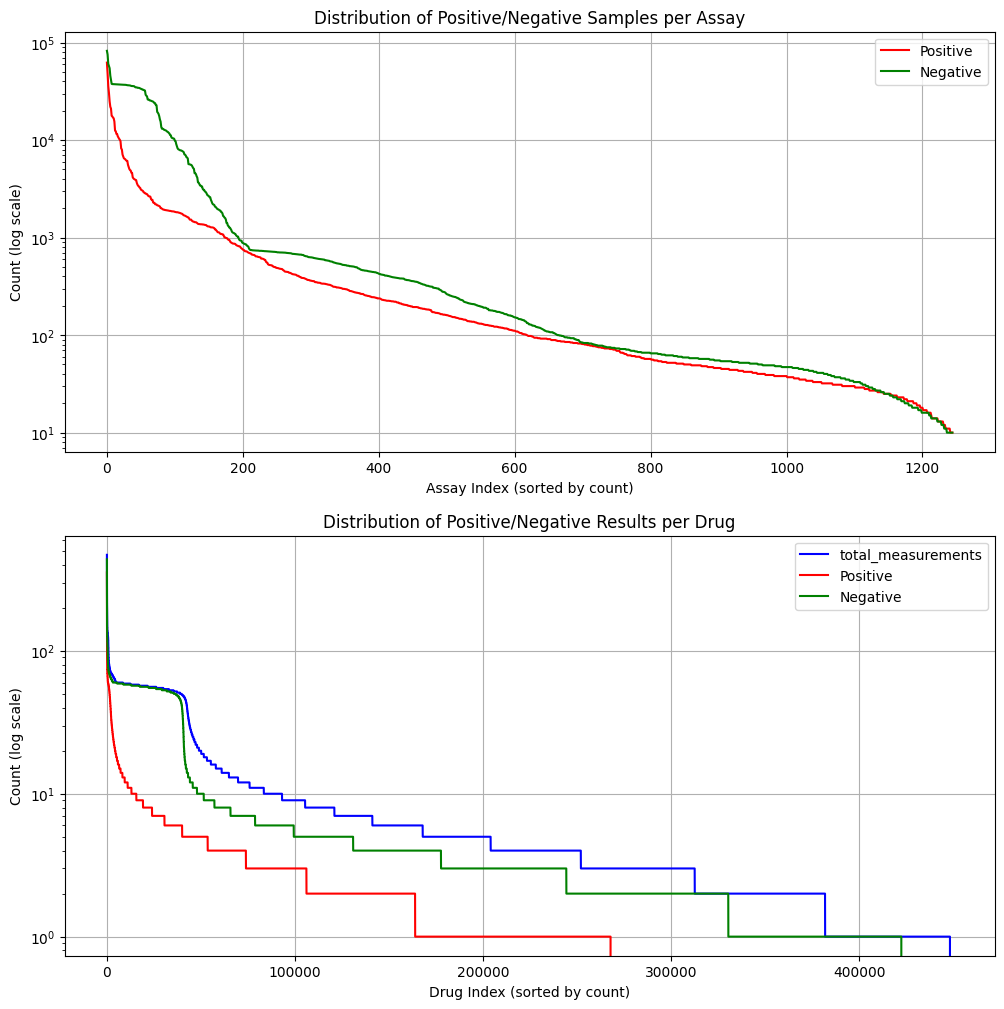

In [10]:
import matplotlib.pyplot as plt

# Create figure with three subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot 1: Distribution in Assays
pos_assays = pos_counts_assays[valid_assays].sort_values(ascending=False)
neg_assays = neg_counts_assays[valid_assays].sort_values(ascending=False)

ax1.plot(pos_assays.values, label='Positive', color='red')
ax1.plot(neg_assays.values, label='Negative', color='green')
ax1.set_yscale('log')
ax1.set_title('Distribution of Positive/Negative Samples per Assay')
ax1.set_xlabel('Assay Index (sorted by count)')
ax1.set_ylabel('Count (log scale)')
ax1.legend()
ax1.grid(True)

# Plot 2: Distribution in Drugs
pos_drugs = pos_counts_drugs.sort_values(ascending=False)
neg_drugs = neg_counts_drugs.sort_values(ascending=False)

ax2.plot(measurements_per_drug_filtered.values, label='total_measurements', color='blue')
ax2.plot(pos_drugs.values, label='Positive', color='red')
ax2.plot(neg_drugs.values, label='Negative', color='green')
ax2.set_yscale('log')
ax2.set_title('Distribution of Positive/Negative Results per Drug')
ax2.set_xlabel('Drug Index (sorted by count)')
ax2.set_ylabel('Count (log scale)')
ax2.legend()
ax2.grid(True)

# Normalize SMILES 

In [11]:
import pandas as pd
import math
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.MolStandardize import rdMolStandardize
#IPythonConsole.drawOptions.comicMode=True
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.info')
import rdkit
from rdkit.Chem.SaltRemover import SaltRemover
print(rdkit.__version__)
import numpy as np

from multiprocessing import Pool
from tqdm import tqdm

2019.03.1


In [12]:
def standardize(smiles,remover=SaltRemover()):
    config = {}
    config["StandardizeSmiles"] = True
    config["FragmentParent"] = False
    config["SaltRemover"] = True
    config["isomericSmiles"] = False
    config["kekuleSmiles"] = True
    config["canonical"] = True
    # follows the steps in
    # https://github.com/rdkit/rdkit/blob/master/Docs/Notebooks/MolStandardize.ipynb
    try:
        if config["StandardizeSmiles"]:
            # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule

                smiles = rdMolStandardize.StandardizeSmiles(smiles)

        mol = Chem.MolFromSmiles(smiles)
        # remove salts
        if config["SaltRemover"]:
            mol = remover.StripMol(mol, dontRemoveEverything=False) 

        if config["FragmentParent"]:
            mol = rdMolStandardize.FragmentParent(mol) 

        if config["kekuleSmiles"]:
            Chem.Kekulize(mol, clearAromaticFlags=True)
        normalized_smiles = Chem.MolToSmiles(mol, 
                            isomericSmiles = config["isomericSmiles"],
                            kekuleSmiles = config["kekuleSmiles"],
                            canonical = config["canonical"],
                            allHsExplicit = False)
        if normalized_smiles == '':
            normalized_smiles = np.nan
    except:
        normalized_smiles = np.nan
    return normalized_smiles

def normalize_smiles_parallel(smiles_list):
    with Pool() as pool:
        results = []
        total = len(smiles_list)
        with tqdm(total=total, ncols=80, desc="Processing") as pbar:
            for normalized_smiles in pool.imap(standardize, smiles_list):
                results.append(normalized_smiles)
                pbar.update(1)
    return results

In [13]:
filtered_by_assays.smiles

0                                 c1ccc2cc(CC3=NCCN3)ccc2c1
1                         CCCCCCC=CCCCCCCCc1cccc(O)c1C(=O)O
2                            CC(=O)c1cc2c(cc1O)OC(C)(C)C=C2
3         CCCCCn1cc(C(=O)NC2C3CC4CC(C3)CC2C4)c(=O)c2ccccc21
4         [H]C12Cc3c([nH]c4ccccc34)C(c3ccccc3)N1C(=O)C(C...
                                ...                        
449385               COC(=O)CCCC=C1SCC(NC(=O)c2ccccc2)C1=NO
449386                   CC(=NNC(=O)c1ccccc1F)c1ccc(C#N)cc1
449387    CC1=CC=CC2=NC(=NS(=O)(=O)c3ccc(F)cc3F)c3ccccc3...
449388          CCCC12CN3CCN(CC(C3)C1=NNC(=O)c1ccc(F)cc1)C2
449389            COCc1cc(C)nc(OCC(=O)NN=Cc2ccc(O)cc2)c1C#N
Name: smiles, Length: 449390, dtype: object

In [ ]:
print(filtered_by_assays.smiles.nunique())
normalized_smiles_list = normalize_smiles_parallel(filtered_by_assays.smiles.tolist())
filtered_by_assays['Normalized_SMILES'] = normalized_smiles_list

print(filtered_by_assays.Normalized_SMILES.nunique())

449390


Processing:   1%|▏                       | 3368/449390 [00:13<24:55, 298.34it/s][09:16:04] Can't kekulize mol.  Unkekulized atoms: 3 5

RDKit ERROR: [09:16:04] Can't kekulize mol.  Unkekulized atoms: 3 5
[09:16:04] Can't kekulize mol.  Unkekulized atoms: 3 5

RDKit ERROR: [09:16:04] Can't kekulize mol.  Unkekulized atoms: 3 5
RDKit ERROR: 
RDKit ERROR: 
Processing:   7%|█▍                     | 29308/449390 [01:58<30:01, 233.21it/s]RDKit ERROR: [09:17:49] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 7
RDKit ERROR: 
[09:17:49] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 7

Processing:   9%|██                     | 40754/449390 [02:44<26:54, 253.04it/s][09:18:36] Can't kekulize mol.  Unkekulized atoms: 3 5 27 28 29 31

Processing:   9%|██                     | 40780/449390 [02:44<29:58, 227.17it/s]RDKit ERROR: [09:18:36] Can't kekulize mol.  Unkekulized atoms: 3 5 27 28 29 31
RDKit ERROR: 
Processing:  15%|███▍                   | 67758/449390 [04:35<22:24, 283.89it/s][09:20:26] C